We scanned 10 fishes for Carolina, let's preview them.

In [1]:
import platform
import os
import glob
import pandas
import numpy
import imageio
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
from numcodecs import Blosc
from tqdm import notebook

/home/habi/miniconda3/envs/nadia-cox7a/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})
print('Dask temporary files to to %s' % dask.config.get('temporary_directory'))

Dask temporary files to to /media/habi/Fast_SSD/tmp


In [3]:
# Start dask client and tell where we can see what it does
client = Client()
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

/home/habi/miniconda3/envs/nadia-cox7a/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45393 instead
  warnings.warn(


You can seee what DASK is doing at "http://localhost:45393/status"


In [4]:
# # https://stackoverflow.com/a/62242245/323100
# import warnings
# warnings.filterwarnings('ignore')

In [5]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 300  # Increase dpi

In [6]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [7]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [8]:
# Different locations if running either on Linux or Windows
if 'anaklin25' in platform.node():
    FastSSD = True
else:
    FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    BasePath = os.path.join('/Users/habi/Data')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('F:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'Zebrafish_Carolina_Muscles')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Zebrafish_Carolina_Muscles


In [9]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    pixelsize = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [10]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    ringartefactcorrection = numpy.nan
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [11]:
def get_reconstruction_grayvalue(logfile):
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [12]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [13]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [14]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to /home/habi/P/Documents/Zebrafish-Carolina/Output/4faa861


In [15]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [16]:
# Get *all* log files in the root folder
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'),
                                               recursive=True))]

In [17]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [18]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [19]:
print('We found %s subfolders in %s' % (len(Data), Root))

We found 20 subfolders in /media/habi/Fast_SSD/Zebrafish_Carolina_Muscles


In [20]:
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]

In [21]:
# We did several reconstruction for each fish (i.e. also one without a roi)
# Grab the name of those here
Data['RecFolder'] = [os.path.basename(os.path.dirname(l)) for l in Data['LogFile']]

In [22]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [23]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for sample in Data[Data['Number of reconstructions'] == 0]['Sample']:
    print('%s has not been reconstructed yet, we remove it from our data temporarily' % sample)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

ko01 has not been reconstructed yet, we remove it from our data temporarily
ko02 has not been reconstructed yet, we remove it from our data temporarily
ko03 has not been reconstructed yet, we remove it from our data temporarily
ko04 has not been reconstructed yet, we remove it from our data temporarily
ko05 has not been reconstructed yet, we remove it from our data temporarily
wt01 has not been reconstructed yet, we remove it from our data temporarily
wt02 has not been reconstructed yet, we remove it from our data temporarily
wt03 has not been reconstructed yet, we remove it from our data temporarily
wt04 has not been reconstructed yet, we remove it from our data temporarily
wt05 has not been reconstructed yet, we remove it from our data temporarily
We have 10 folders with reconstructions


In [24]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['Beamhardening'] = [get_beamhardening(log) for log in Data['LogFile']]
Data['ReconstructionGrayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]

In [25]:
# Are the samples reconstructed equally?
Data

,LogFile,Folder,Sample,RecFolder,Reconstructions,Number of reconstructions,Voxelsize,RingartefactCorrection,Beamhardening,ReconstructionGrayvalue
0,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,ko01,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,2804,7.99995,7,0,0.123456
1,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,ko02,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,2878,7.99995,7,0,0.123456
2,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,ko03,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,2955,7.99995,7,0,0.123456
3,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,ko04,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,2783,7.99995,7,0,0.123456
4,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,ko05,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,2696,7.99995,7,0,0.123456
5,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,wt01,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,3156,7.99995,7,0,0.123456
6,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,wt02,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,3211,7.99995,7,0,0.123456
7,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,wt03,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,3027,7.99995,7,0,0.123456
8,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,wt04,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,3094,7.99995,7,0,0.123456
9,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,/media/habi/Fast_SSD/Zebrafish_Carolina_Muscle...,wt05,rec_no_roi,[/media/habi/Fast_SSD/Zebrafish_Carolina_Muscl...,3051,7.99995,7,0,0.123456


In [26]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
print('We scanned all samples with', end=' ')
if len(Data['Voxelsize'].round(2).unique())>1:
    print('%s different voxel sizes' % len(Data['Voxelsize'].round(2).unique()))
    for vs in sorted(Data['Voxelsize'].round(2).unique()):
        print('-', vs, 'um for Samples ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'],2):
                print(row.Sample, end=', ')
        print('')
else:
    print('equal voxel size, namely %s um.' % Data['Voxelsize'].unique()[0])

We scanned all samples with equal voxel size, namely 7.99995 um.


In [27]:
# Check beam hardening
# If different, spit out which values
print('We reconstructed all samples with', end=' ')
if len(Data['RingartefactCorrection'].round(2).unique())>1:
    print('%s different RAC' % len(Data['RingartefactCorrection'].round(2).unique()))
    for rac in sorted(Data['RingartefactCorrection']):
        print('-', rac, 'for Samples ', end='')
        for c, row in Data.iterrows():
            print(row.Sample, end=', ')
        print('')
else:
    print('equal ringartefact correction, namely %s.' % Data['RingartefactCorrection'].unique()[0])

We reconstructed all samples with equal ringartefact correction, namely 7.


In [28]:
# Check beam hardening
# If different, spit out which values
print('We reconstructed all samples with', end=' ')
if len(Data['Beamhardening'].round(2).unique())>1:
    print('%s different beam-hardening correction' % len(Data['Beamhardening'].round(2).unique()))
    for bh in sorted(Data['Beamhardening']):
        print('-', bh, 'for Samples ', end='')
        for c, row in Data.iterrows():
            print(row.Sample, end=', ')
        print('')
else:
    print('equal beam-hardening correction, namely %s.' % Data['Beamhardening'].unique()[0])

We reconstructed all samples with equal beam-hardening correction, namely 0.


In [29]:
# Check reconstruction gray value
# If different, spit out which values
print('We reconstructed all samples with', end=' ')
if len(Data['ReconstructionGrayvalue'].round(2).unique())>1:
    print('%s different max. grayvalue' % len(Data['ReconstructionGrayvalue'].unique()))
    for recgv in sorted(Data['ReconstructionGrayvalue'].unique()):
        print('-', recgv, ' for Samples ', end='')
        for c, row in Data[Data['ReconstructionGrayvalue'] == recgv].iterrows():
            print(os.path.join(row.Sample, row.RecFolder), end=', ')
        print('')
else:
    print('equal max. gray value, namely %s.' % Data['ReconstructionGrayvalue'].unique()[0])

We reconstructed all samples with equal max. gray value, namely 0.123456.


In [30]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

/tmp/ipykernel_1765523/2063428869.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  Data['PreviewImage'] = [imageio.imread(pip[0])


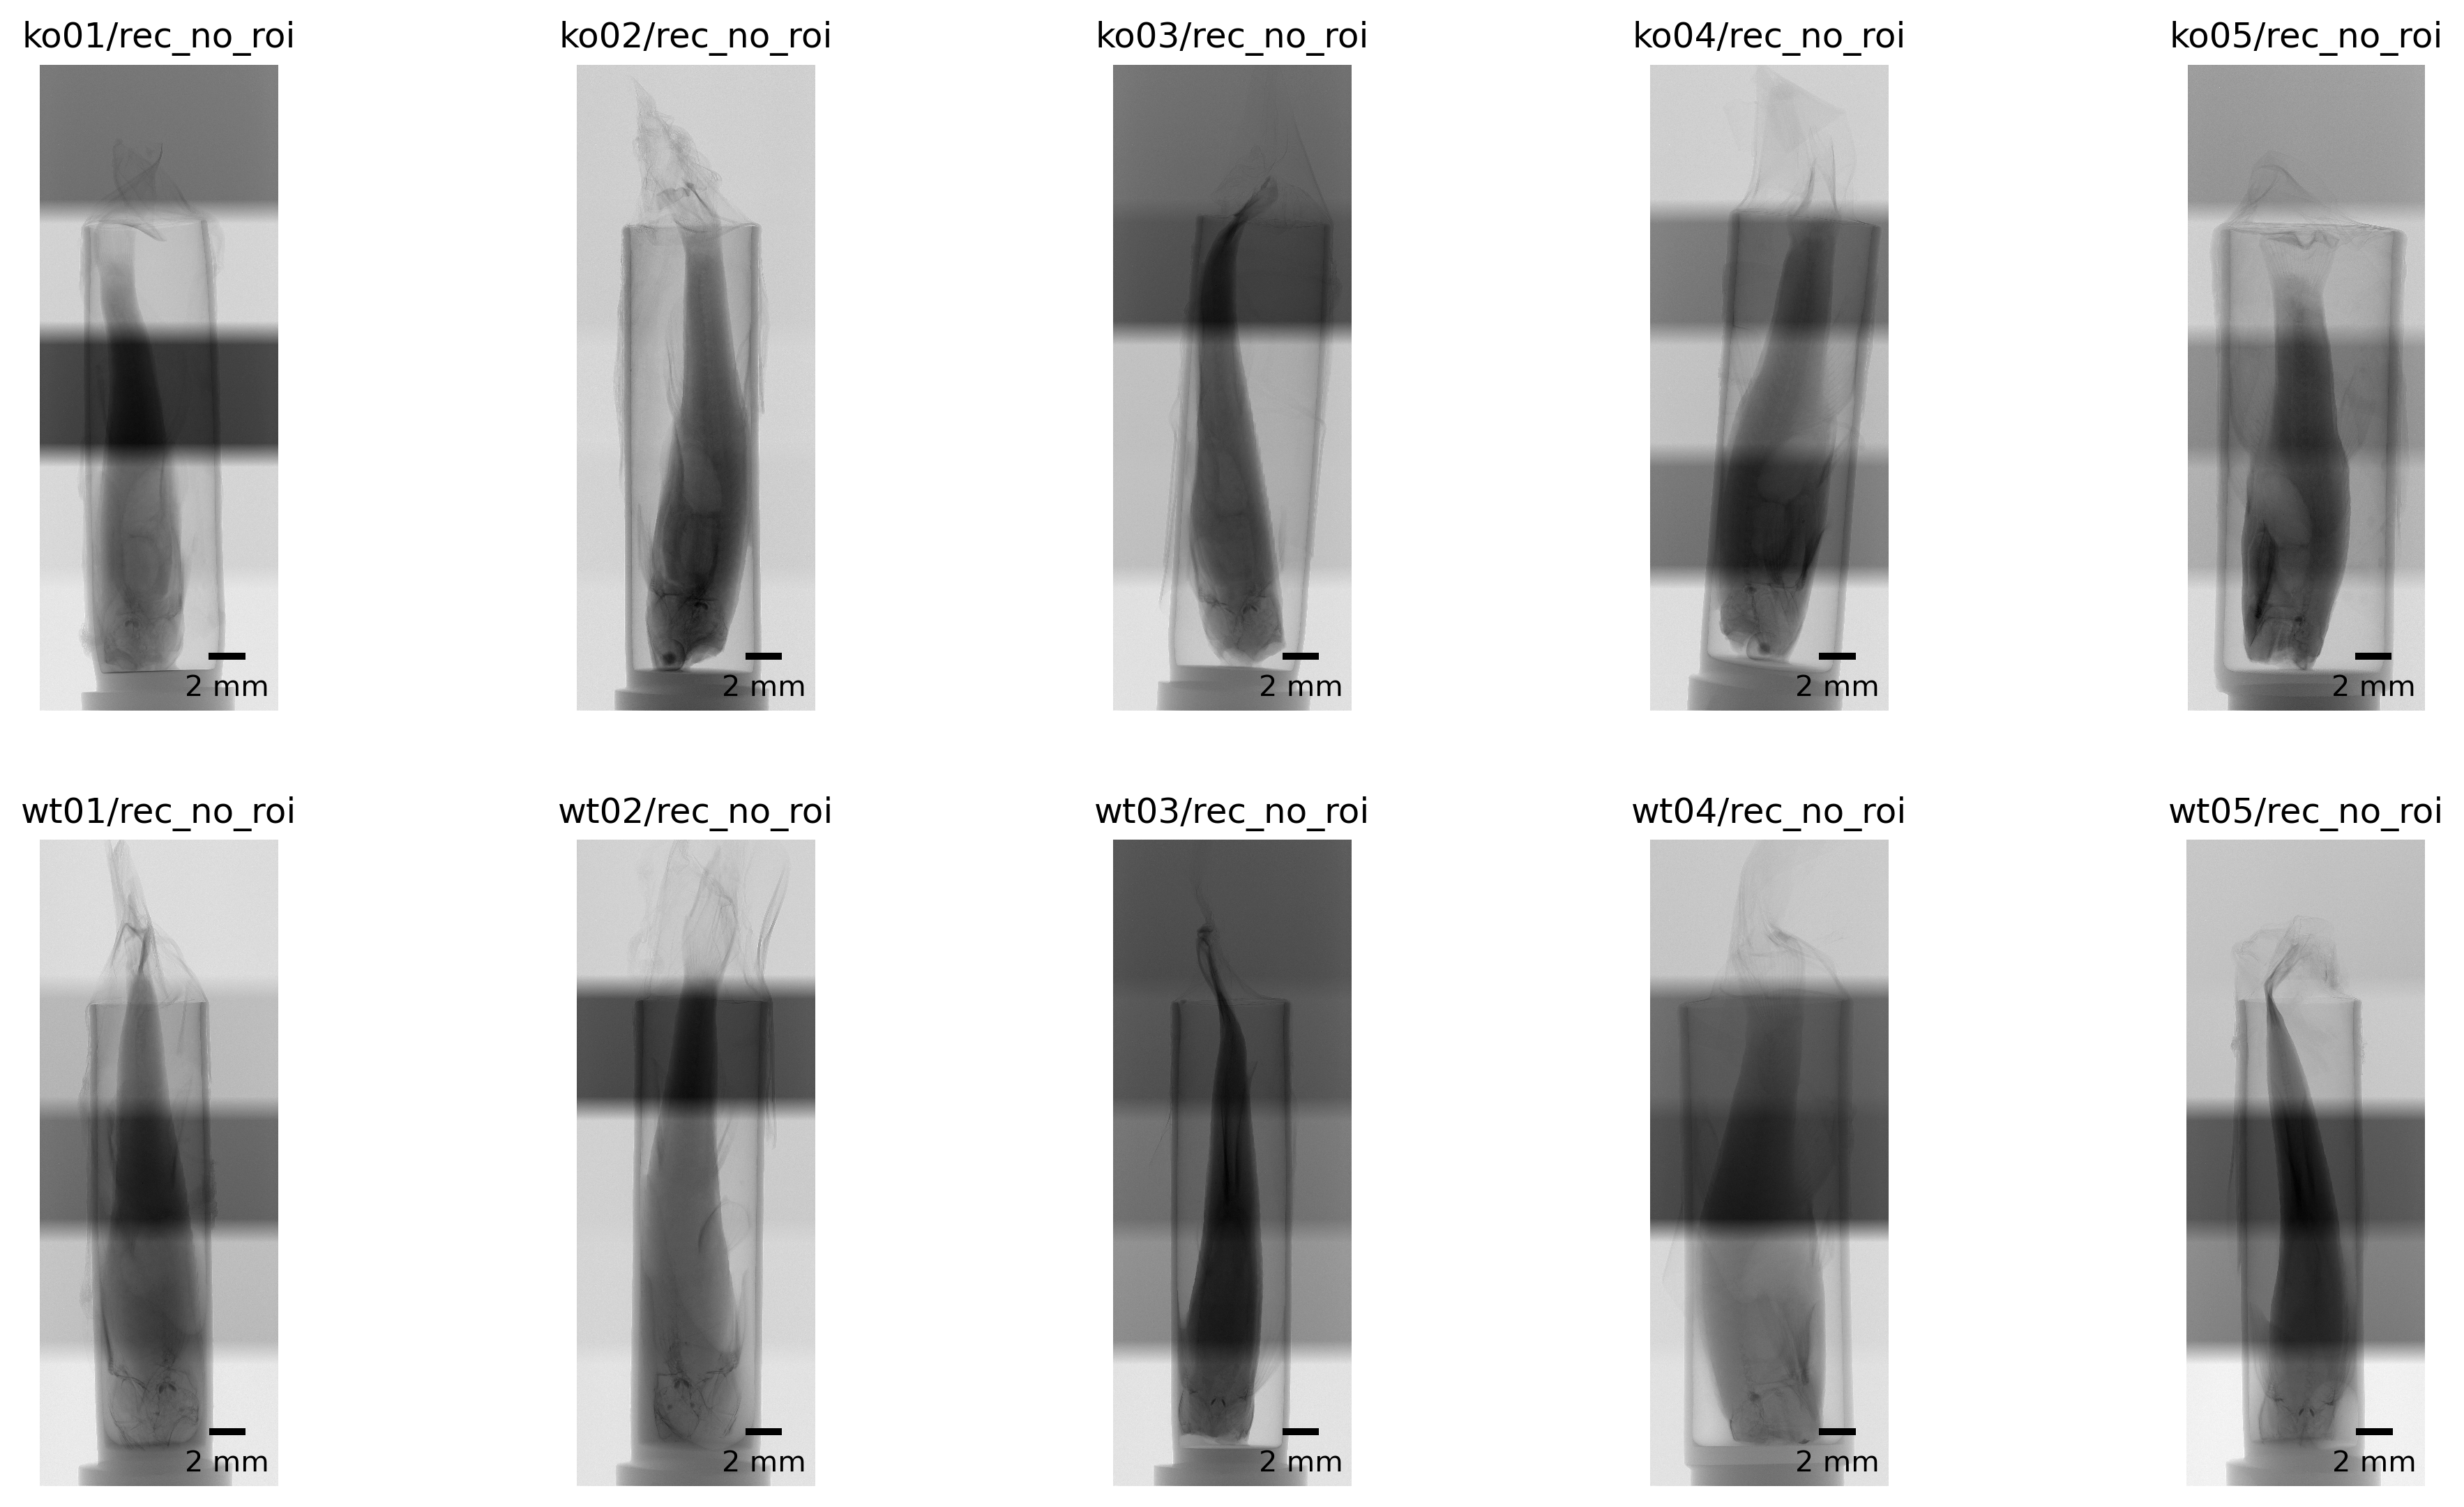

In [31]:
for c,row in Data.iterrows():
# for c,row in Data[Data.RecFolder == 'rec'].iterrows():
    plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(os.path.join(row.Sample, row.RecFolder))
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color='black'))
    plt.axis('off')
plt.show()

In [45]:
# Convert all reconstructions into a zarray and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [((os.path.join(os.path.dirname(f), s)) + '.' + rf + '.zarr') for f,s,rf in zip(Data['Folder'], Data['Sample'], Data['RecFolder'])]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%2s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root)+1:]))       
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))
        # Save out to rechunked and compressed zarr files.
        # This takes a *long* time, but subsequent operations are much quicker afterwards
        Reconstructions.rechunk(200).to_zarr(row['OutputNameRec'],
                                             overwrite=True,
                                             compressor=Blosc(cname='zstd',
                                                              shuffle=Blosc.BITSHUFFLE))        

In [33]:
# Load the reconstructions from the as zarrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

ArrayNotFoundError: array not found at path %r' ''

In [ ]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [ ]:
# The three cardinal directions
# Names adapted to fishes: https://en.wikipedia.org/wiki/Fish_anatomy#Body
directions = ['Anteroposterior',
              'Lateral',
              'Dorsoventral']

In [ ]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = ''
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Middle.%s.png' % (row['Sample'], row['RecFolder'], direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Anteroposterior' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Lateral' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Dorsoventral' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [ ]:
# Show middle slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving middle images overview', total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.%s.MiddleSlices.png' % (row['Sample'], row['RecFolder']))
    if not os.path.exists(outfilepath):    
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_' + direction])
            if d==0:
                plt.axhline(row.Size[1]//2, c=seaborn.color_palette()[0])
                plt.axvline(row.Size[2]//2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[2]))
            elif d==1:
                plt.axhline(row.Size[0]//2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[2]//2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[0]))
            else:
                plt.axhline(row.Size[0]//2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[1]//2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um', color=seaborn.color_palette()[1]))
            plt.title('%s, %s' % (os.path.join(row['Sample'], row['RecFolder']),
                                  direction + ' Middle slice'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [ ]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc=row['Sample'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']), '%s.%s.MIP.%s.png' % (row['Sample'], row['RecFolder'], direction))
        if os.path.exists(outfilepath):
            Data.at[c,'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c,'MIP_' + direction] = Reconstructions[c].max(axis=-d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c,'MIP_' + direction].astype('uint8'))

In [ ]:
# Show MIP slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving MIP images overview', total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']), row['Sample'] + '.%s.MIPs.png' % os.path.basename(row['Folder']))
    if not os.path.exists(outfilepath):       
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Sample'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
            plt.title('%s, %s' % (os.path.join(row['Sample'], row['RecFolder']),
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath, bbox_inches='tight')
        plt.show()

In [ ]:
if len(Data['RecFolder'].unique()):
    print('Done with the preparation of %s different reconstructions of %s samples!' % (len(Data['RecFolder'].unique()),
                                                                                        len(Data)//len(Data['RecFolder'].unique())))
else:
    print('Done with the preparation of %s scans!' % len(Data))